# **Importing the necessary libraries**

In [1]:
pip install tensorflow-io

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import VGG16

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Retrieving the list of all class names from the custom dataset uploaded on kaggle

In [3]:
classes = os.listdir('/kaggle/input/suspicious-activity-vandalism/Suspicious_activity 2/Dataset')
classes

['Vandalism', 'walking', 'running', 'fights']

## Randomly Selecting and Displaying Video Frames from Dataset

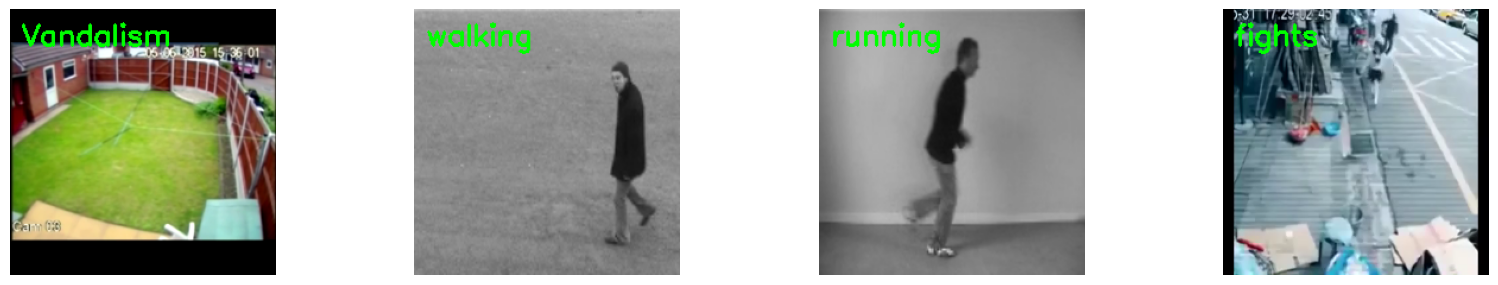

In [4]:
#Selecting randomness
seed_constant = 3
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

plt.figure(figsize = (20, 20))
 
# Displaying Random Video Frames from Dataset
for counter, index in enumerate(range(len(classes)), 1):
    selected_class = classes[index]
    video_files_list = os.listdir(f'/kaggle/input/suspicious-activity-vandalism/Suspicious_activity 2/Dataset/{selected_class}')
    selected_video_file = random.choice(video_files_list)
 
    video_reader = cv2.VideoCapture(f'/kaggle/input/suspicious-activity-vandalism/Suspicious_activity 2/Dataset/{selected_class}/{selected_video_file}')
    video_reader.set(1, 25)

    _, bgr_frame = video_reader.read()
    bgr_frame = cv2.resize(bgr_frame ,(224,224))

    video_reader.release()
 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Writing the class name on the video frame.
    cv2.putText(rgb_frame, selected_class, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    
    # Displaying the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

# Specifying Data Variables

In [5]:
dataset_path = "/kaggle/input/suspicious-activity-vandalism/Suspicious_activity 2/Dataset"

img_height = 64
img_width = 64
 
seq_len = 30

# Data preprocessing and creating dataset

In [6]:
def extracting_frames(path):
    
    frames_list = []
    video_reader = cv2.VideoCapture(path)
    frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skipped_frames = max(int(frame_count/seq_len), 1)

    
    # Creating an ImageDataGenerator object to perform data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2,
        horizontal_flip=True,
         # Adjust brightness
        brightness_range=(0.8, 1.2), 
        # Apply shear transformation
        shear_range=10,  
        # Apply random channel shifts
        channel_shift_range=20,  
        # Handling boundary pixels during transformations
        fill_mode='reflect'  
    )

    
    for frame_counter in range(seq_len):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skipped_frames)
        success, frame = video_reader.read() 


        if not success:
            break

        resized_frame = cv2.resize(frame, (img_height, img_width))
        aug_frame = datagen.random_transform(resized_frame)
        normalized_frame = aug_frame / 255  
        frames_list.append(normalized_frame)
        
    video_reader.release()

    return frames_list

In [7]:
def dataset_creation():

    features = []
    paths = []
    labels = []
    
    for index_of_class, name_of_class in enumerate(classes):
        
        print('Extracting Data of Class:', name_of_class)
        list_of_files = os.listdir(os.path.join(dataset_path, name_of_class))
        
        for file in list_of_files:
            
            video_file_path = os.path.join(dataset_path, name_of_class, file)
            frames = extracting_frames(video_file_path)
            
            if len(frames) == seq_len:
                features.append(frames)
                labels.append(index_of_class)
                paths.append(video_file_path)
                
    features = np.asarray(features)
    labels = np.array(labels)  
    
    return features, paths, labels

In [8]:
features, paths, labels = dataset_creation()
print(features.shape, labels.shape)

Extracting Data of Class: Vandalism
Extracting Data of Class: walking
Extracting Data of Class: running
Extracting Data of Class: fights
(783, 30, 64, 64, 3) (783,)


# One Hot Encoding and Data Splitting

In [9]:
one_hot_encoded_labels = to_categorical(labels)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

# Model Creation

In [10]:
def creating_model():
    model = Sequential()
    
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
    for layer in vgg.layers:
        layer.trainable = False
    model.add(TimeDistributed(vgg, input_shape=(seq_len, img_height, img_width, 3)))
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu'), input_shape = (seq_len, img_height, img_width, 3)))
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(Flatten()))
    
    model.add(LSTM(32))
    
    model.add(Dense(len(classes), activation='softmax'))

    model.summary()
    
    return model

In [11]:
num_classes = len(classes)
lstm_models = []
num_models = 6

# Training multiple LSTM models with initialization or hyperparameters
training_histories = []
for i in range(num_models):
    lstm_model = creating_model()
    lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    early_stopping_callback = EarlyStopping(monitor = 'accuracy', patience = 10, mode = 'max', restore_best_weights = True)
    training_history = lstm_model.fit(x = features_train, y = labels_train, epochs = 30, batch_size = 4 , shuffle = True, validation_split = 0.25, callbacks = [early_stopping_callback])
    lstm_models.append(lstm_model)
    training_histories.append(training_history)

# Combining the predictions of the multiple LSTM models using majority voting
y_pred = []
for i in range(len(features_test)):
    predictions = []
    for model in lstm_models:
        predictions.append(np.argmax(model.predict(np.expand_dims(features_test[i],axis =0))[0]))
    y_pred.append(max(set(predictions), key=predictions.count))


# Converting the predicted labels to one-hot encoding
y_pred = tf.keras.utils.to_categorical(y_pred, num_classes)

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 2, 2, 512)    14714688  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 2, 2, 32)     147488    
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 2, 2, 64)     18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 256)          0         
 tributed)                                                       
                                                         

# Accuracy and Model Saving

In [12]:
accuracy = tf.keras.metrics.CategoricalAccuracy()
accuracy.update_state(labels_test, y_pred)
print(f"Ensemble model accuracy: {accuracy.result().numpy()}")

Ensemble model accuracy: 0.9081632494926453


In [ ]:
model.save("/kaggle/working/Suspicious_Human_Activity_Detection.h5")

# Video Annonation

In [26]:
def Video_Annonation(input_path, output_path, seq_len):

    vid_reader = cv2.VideoCapture(input_path)
 
    Original_width = int(vid_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    Original_height = int(vid_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    vid_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   vid_reader.get(cv2.CAP_PROP_FPS), (Original_width, Original_height))
 
    queue = deque(maxlen = seq_len)
    
    datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2,
        horizontal_flip=True,
         # Adjust brightness
        brightness_range=(0.8, 1.2), 
        # Apply shear transformation
        shear_range=10,  
        # Apply random channel shifts
        channel_shift_range=20,  
        # Handling boundary pixels during transformations
        fill_mode='reflect'  
    )
 
    prediction = ''
 
    while vid_reader.isOpened():
 
        ok, frame = vid_reader.read() 
        
        if not ok:
            break
            
        resized_frame = cv2.resize(frame, (img_height, img_width))
        aug_frame = datagen.random_transform(resized_frame)
        normalized_frame = aug_frame / 255  
 
        queue.append(normalized_frame)
 
        if len(queue) == seq_len:
 
            predicted_label = np.argmax(model.predict(np.expand_dims(queue, axis = 0))[0])
 
            prediction = classes[predicted_label]
 
        cv2.putText(frame, prediction, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
 
        vid_writer.write(frame)
        
    vid_reader.release()
    vid_writer.release()

In [27]:
input_path = "/kaggle/input/suspicious-activity-vandalism/Suspicious_activity 2/Dataset/Vandalism/15r.mp4"
output_path = "/kaggle/working/15r.mp4"

In [28]:
Video_Annonation(input_path, output_path, seq_len)

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


1/1 [==============================] - 0s 22ms/step


# Motionless Bag Detection

In [29]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 603.9/603.9 kB 9.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import cv2
import numpy as np
import time

# Load YOLOv5 model
device = torch.device('cpu')
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True).to(device)

# Define the class labels to detect
class_labels = [24, 28, 26]

# Load video
video_path = '/kaggle/working/15r.mp4'
cap = cv2.VideoCapture(video_path)

# Get video properties
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Define output video writer
output_path = '/kaggle/working/Final_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Get class names associated with YOLOv5 model
class_names = model.module.names if hasattr(model, 'module') else model.names

# Variables for bag movement detection
threshold = 1000  # Threshold value for bag movement
duration_threshold = 2  # Duration threshold in seconds
bag_position = None  # Position of the bag (center of bounding box)
duration = 0  # Duration of the bag within the threshold
last_detection_time = 0  # Time of the last detection

while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break

    # Perform inference on the frame
    results = model(frame)

    # Get bounding box coordinates and labels
    boxes = results.pred[0].detach().cpu().numpy()[:, :4]
    labels = results.pred[0].detach().cpu().numpy()[:, -1]

    # Filter the bounding boxes and labels based on class labels
    filtered_boxes = []
    filtered_labels = []
    for box, label in zip(boxes, labels):
        if label in class_labels:
            filtered_boxes.append(box)
            filtered_labels.append(class_names[int(label)])  # Get class name based on label

    # Draw bounding boxes and labels on the frame
    for box, label in zip(filtered_boxes, filtered_labels):
        x1, y1, x2, y2 = box.astype(int)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Check if bag is within threshold
    if len(filtered_boxes) > 0:
        x1, y1, x2, y2 = filtered_boxes[0].astype(int)
        bag_x = (x1 + x2) // 2  # Calculate bag's x-coordinate
        bag_y = (y1 + y2) // 2  # Calculate bag's y-coordinate

        if bag_position is None:
            bag_position = (bag_x, bag_y)
            last_detection_time = time.time()
        else:
            # Calculate Euclidean distance between current and previous position
            distance = np.sqrt((bag_x - bag_position[0]) ** 2 + (bag_y - bag_position[1]) ** 2)

            if distance <= threshold:
                duration += 1 / fps  # Increase duration by frame duration

                if duration >= duration_threshold:
                    # Bounding box color becomes red
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
                    cv2.putText(frame, str(int(duration)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9,
                                (0, 0, 255), 2)
            else:
                current_time = time.time()
                elapsed_time = current_time - last_detection_time

                if elapsed_time >= 1:
                    # Bounding box color becomes green, restart duration
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(frame, str(int(duration)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9,
                                (0, 255, 0), 2)
                    bag_position = (bag_x, bag_y)
                    duration = 0
                    last_detection_time = current_time

    # Write annotated frame to output video
    out.write(frame)

# Release video capture and writer
cap.release()
out.release()


# Metrics Graphs